In [1]:
display(HTML("<style>.rendered_html.text_cell_render {max-width:700px; }</style>"));

HTML{String}("<style>.rendered_html.text_cell_render {max-width:700px; }</style>")

# Create Observations along path

In [3]:
push!(LOAD_PATH, "src");
using MyUtils
using Geometry
import JSON
using Colors, Plots
col = palette(:default);

fname = "data/path_data_big.json"
d = JSON.parsefile(fname)

println(keys(d))

segs = segments(Array{Float64}.(d["verts"]));
paths = [Array{Float64}.(path) for path in d["paths"]];

["env_name", "verts", "paths"]


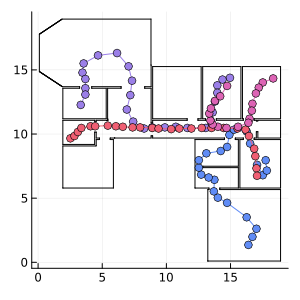

In [4]:
myplot = plot(size=(300,300), aspect_ratio=:equal)
plot!(segs, label=nothing, c="black")
for path in paths
    plot!(path, marker=:o, label=nothing)
end
myplot

(25,)(25,)(24,)(24,)


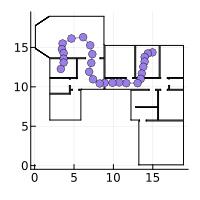

In [10]:
# Choose path
i = 1
path = paths[i]

# Unpack path into 
# poses and controls
xs   = path
dxs  = xs[2:end] - xs[1:end-1]
hds  = angle.(dxs)
dhds = hds[2:end] - hds[1:end-1];
xs   = xs[1:end-1]
dxs  = dxs[1:end-1]


println(size(xs), size(hds), size(dxs), size(dhds))
    
plot(size=(200,200), aspect_ratio=:equal)
plot!(segs, label=nothing, c="black")
plot!(path, marker=:o, label=nothing)

In [11]:
fov  = 2π
zmax = 20
as = collect(range(-fov/2,fov/2, 361))

# Compute measurements along path
zs = []
for (x,hd) in zip(xs, hds)
    push!(zs, cast(x, hd, as, segs))
end
    
size(zs)

(25,)

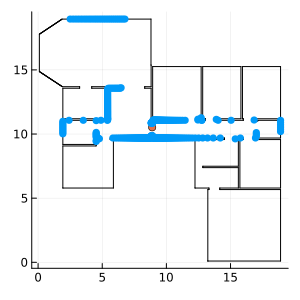

In [14]:
t = rand(1:length(xs))
z = zs[t]
x = xs[t]
hd = hds[t]

obs = [x] .+ z .* unit_vec.(as .+ hd)

# -------------------
myplot = plot(size=(300,300), aspect_ratio=:equal, legend=nothing)
plot!(segs, label=nothing, c="black")
scatter!([x[1]], [x[2]], c=col[2])
scatter!(obs, markerstrokewidth=0.0, c=col[1])

In [15]:
data = Dict(
    :env => Dict(
        :segs => segs
    ),
    :motion => Dict(
        :x => xs,
        :hd => hds,
        :dx => dxs,
        :dhd => dhds
    ),
    :sensor => Dict(
        :a => as,
        :z => zs,
        :fov => fov,
        :zmax => zmax
    )
)

using JLD2
fname = "data/data_3.jld2"
save_object(fname, data)

In [79]:
data = load_object(fname)

Dict{Symbol, Dict{Symbol}} with 3 entries:
  :env    => Dict{Symbol, Vector{Segment}}(:segs=>[Segment([0.11, 0.1], [0.1, 0…
  :sensor => Dict{Symbol, Any}(:a=>[-3.14159, -3.12414, -3.10669, -3.08923, -3.…
  :motion => Dict{Symbol, Vector}(:x=>[[1.09725, 1.10467], [1.26401, 1.2476], […

In [18]:
data = Dict(
    :env => Dict(
        :segs => Geometry.vec.(segs)
    ),
    :motion => Dict(
        :x   => xs,
        :hd  => hds,
        :dx  => dxs,
        :dhd => dhds
    ),
    :sensor => Dict(
        :a => as,
        :z => zs,
        :fov  => fov,
        :zmax => zmax
    )
)

fname = "data/data_3.json"
open(fname,"w") do f
    JSON.print(f, data)
end

## Unpack Data

In [140]:
#nbx --fname="src/unpack_data.jl"
push!(LOAD_PATH, "src");
using JLD2
using StatsBase: mean
using Geometry: bounding_box, Segment
using GridSlam: Pose, Measurement

fname = "data/data_3.jld2"
d = load_object(fname)

# Environment
_segs   = env_segs = d[:env][:segs];
_center = mean(bounding_box(_segs))

# Poses
_xs   = d[:motion][:x];
_hds  = d[:motion][:hd];
_ps   = [Pose(x,hd) for (x,hd) in zip(_xs, _hds)];

# Controls
_dxs  = d[:motion][:dx]
_dhds = d[:motion][:dhd]
_us   = [(dx,dhd) for (dx,dhd) in zip(_dxs, _dhds)]

# Sensor and measurements
_as    = d[:sensor][:a];
_num_a = _na = length(_as)
_zs   = d[:sensor][:z];
_ss   = [Measurement.(z,_as) for z in _zs]
_fov  = d[:sensor][:fov]
_zmax = d[:sensor][:zmax]

_T = length(_zs);

In [139]:
#nbx
println("Loading `$(fname)` ...\n")
for x in [:_segs, :_xs, :_hds, :_ps, :_dxs, :_dhds, :_us, :_as, :_zs, :_ss, :_fov, :_zmax, :_T]
    local y = getproperty(Main,x)
    println("\t$(x) \t$(typeof(y))")
end
println("\nTo take a look call `glimpse_at_data(_segs, _ps, _ss)`")

Loading `data/data_3.jld2` ...

	_segs 	Vector{Segment}
	_xs 	Vector{Vector{Float64}}
	_hds 	Vector{Float64}
	_ps 	Vector{Pose}
	_dxs 	Vector{Vector{Float64}}
	_dhds 	Vector{Float64}
	_us 	Vector{Tuple{Vector{Float64}, Float64}}
	_as 	Vector{Float64}
	_zs 	Vector{Any}
	_ss 	Vector{Vector{Measurement}}
	_fov 	Float64
	_zmax 	Int64
	_T 	Int64

To take a look call `glimpse_at_data(_segs, _ps, _ss)`


In [136]:
#nbx
using Colors, Plots
col = palette(:default);

function glimpse_at_data(_segs, _ps, _ss, t=nothing)
    t = t == nothing ? rand(1:_T) : t;
    # -----------------
    myplot = plot(size=(350,350), aspect_ratio=:equal, legend=false)
    plot!(_segs, c=:black)
    plot!([p.x for p in _ps], marker=:o, label=nothing, markersize=2, c=col[1], alpha=0.5)
    scatter!([_ps[t].x], markersize=4, marker=:^, c=:red)
    scatter!(_ps[t], _ss[t], markersize=2, alpha=1, markerstrokewidth=0., marker=:o, c=col[2])
    display(myplot)
end;

glimpse_at_data (generic function with 4 methods)

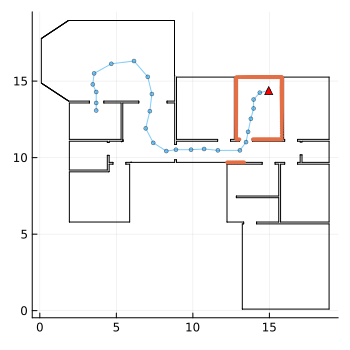

In [133]:
glimpse_at_data(_segs, _ps, _ss, 1)